### Data Source:
On a weekly basis the City of Scottsdale Police Department publishes a [dataset](http://data.scottsdaleaz.gov/dataset/police-citations)* which includes one prior years worth citations.  These citations are largely made up of vehicle related infractions such as speeding.  

Based on when I downloaded the data over the last few years, my combined dataset includes citations from September 2017 through January 2020.  In raw format the combined dataset includes just over 56K rows and 22 columns.  For privacy issues, the City of Scottsdale does not release citation data for anyone under 18.  

<br/>

*Contains information from the City of Scottsdale Open Database Portal, which is made available here under the [Open Database License](http://www.scottsdaleaz.gov/AssetFactory.aspx?did=69351).


### Notebook Overview:
1. Data Prep
1. EDA
1. Export Features

## DATA PREPROCESSING

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in csv files
files = glob.glob('data/primary_data/*.csv')

citations = pd.concat([pd.read_csv(f) \
                      for f in files], sort=True)

In [4]:
citations.head()

,Arizona Statute Code,Beat,Charge Description,Citation #,Citation Date,Citation Time,Citation Type Code,Citation Type Description,Cited Person,Cited Person Age,Cited Person Ethnicity,Cited Person Race,Cited Person Sex,City,District,Officer Badge #,State,Street,Street Number,Zip,Zone,tcmainid
0,28-701A,12.0,Speed Greater Than R&P or Posted,8096915,07/10/2019,747,CV,Civil Traffic,"Hansen, Christopher",19,N,W,M,Scottsdale,D3,1335,AZ,E Shea Bl,6xxx,NaN,3003,662799
1,28-701A,12.0,Speed Greater Than R&P or Posted,8096916,07/10/2019,800,CV,Civil Traffic,"Koch, JOshua",36,N,W,M,Scottsdale,D3,1335,AZ,E Shea Bl,6xxx,NaN,3003,662801
2,28-701A,7.0,Speed Greater Than R&P or Posted,8096917,07/10/2019,853,CV,Civil Traffic,"Dahl, Renee",61,N,W,F,Scottsdale,D2,1335,AZ,N Goldwater Bl,4xxx,NaN,1102,662802
3,28-701A,7.0,Speed Greater Than R&P or Posted,8096918,07/11/2019,843,CV,Civil Traffic,"Lu, Hung",59,N,A,M,Scottsdale,D2,1335,AZ,N Goldwater Bl,4xxx,NaN,1102,662804
4,28-701A,19.0,Speed Greater Than R&P or Posted,8095091,07/06/2019,2215,CV,Civil Traffic,"Noller-Johnson, Aarron",23,U,W,M,Scottsdale,D4,1450,AZ,N Pima Rd,2xxx,NaN,3801,662805


In [5]:
# for ease of convention convert column labels to lower case 
# and remove spaces from column names
citations.columns = citations.columns.str.replace(' ', '_')
citations.columns = map(str.lower, citations.columns)

In [6]:
# remove duplicate citations due to overlap in data being downloaded
citations.drop_duplicates('citation_#', inplace=True)

In [7]:
# examin null values
citations.isnull().sum()

arizona_statute_code             0
beat                           310
charge_description               0
citation_#                       0
citation_date                    0
citation_time                    0
citation_type_code               0
citation_type_description        0
cited_person                     0
cited_person_age                 0
cited_person_ethnicity          26
cited_person_race                0
cited_person_sex                 3
city                            63
district                       856
officer_badge_#                  0
state                           90
street                           4
street_number                    0
zip                          54159
zone                             4
tcmainid                         0
dtype: int64

In [8]:
# drop citations where beat is null
citations.drop(citations[citations.beat.isnull()].index, inplace=True)

In [9]:
# drop citations where beat is null
citations.drop(citations[citations.street.isnull()].index, inplace=True)

In [10]:
# change data type of age from object to number
citations.cited_person_age = pd.to_numeric(citations.cited_person_age, errors='coerce')

In [11]:
# one citation has no age
# drop citations where age isn't provided

citations.dropna(subset=['cited_person_age'], inplace=True)

In [12]:
# convert citation date to datetime format
citations['citation_date'] = pd.to_datetime(citations['citation_date'])

# create month column
citations['month'] = citations['citation_date'].dt.month

# create day of week column
citations['day_of_week'] = citations['citation_date'].dt.dayofweek

# extract the hour of the day from the citation time column
# hour of day is in non-standard datetime format
citations['hour_of_day'] = citations['citation_time'].apply(lambda x: str(x)[-4:-2])

# replace blanks with 0
# this happened for citations that took place during the hour of 12am
citations.loc[citations.hour_of_day == '', 'hour_of_day'] = 0
# change data type of hour from object to number
citations.hour_of_day = pd.to_numeric(citations.hour_of_day)

In [13]:
# how many rows and columns are in the dataset?
citations.shape

(55747, 25)

## EDA

#### Citation Types

In [14]:
citations.charge_description.value_counts()[citations.charge_description.value_counts().values > 100].tail(10)

Criminal Damage-Deface                     149
False Report to Law Enforcement            146
Adequate Windshield Required-Automobile    145
Drive Wrong Way On One Way Road            130
Liquor-Under 21 Any Liquor In Body         127
Reckless Driving                           120
Waste of Finite Resource <=65mph           114
F/Obey Police Officer                      112
Improper Material/Tint On Window           107
Fail to Yield On Green                     106
Name: charge_description, dtype: int64

In [15]:
# there are a huge number of unique citations
citations.charge_description.nunique()

415

In [16]:
# many of which are received by only a few people 
# roughtly half were issued to fewer than 5 people
citations.charge_description.value_counts()[citations.charge_description.value_counts().values < 5]

No Lic. Driver Age 21+ Beside Person W/ Permit Only    4
Parking On Sidewalk                                    4
Stat Emerg Veh - Yld Rght of Way - Reduce Speed        4
Criminal Damage-Tamper                                 4
Vehicle Must Have Adequate Muffler                     4
                                                      ..
Drive Through Safety Zone                              1
Brakes Inoperable/Defective                            1
Pedestrian Crossing On Red Signal                      1
Permittee Must Possess Instruction Permit              1
Marijuana-Possess/Use                                  1
Name: charge_description, Length: 202, dtype: int64

In [17]:
# many of which are received by only a few people 
citations.charge_description.value_counts()[citations.charge_description.value_counts().values < 5].shape

(202,)

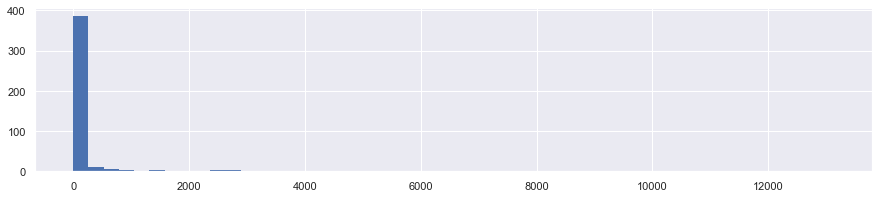

In [18]:
plt.figure(figsize=(15, 3))
plt.hist(citations.charge_description.value_counts().values, bins=50);

In [19]:
citations.charge_description.value_counts().head(12)

Speed Greater Than R&P or Posted                 13137
Expired/No Arizona Registration                   4544
Suspended/Revoked D.L.                            3349
DUI-Impaired to Slightest Degree                  2712
Failure to Control Speed to Avoid A Collision     2653
Drug Paraphernalia-Possess/Use                    2486
No Proof of Insurance                             2475
Fail to Obey Traffic Control Device               1852
Fail to Stop For Red Signal                       1525
Fail to Stop at Stop Sign                         1450
Exceed Limit By More Than 20mph                   1245
Exceed 15mph In School Crossing                    989
Name: charge_description, dtype: int64

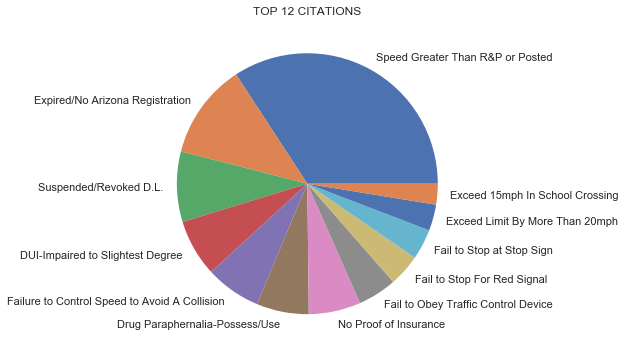

In [20]:
# examine distribution of top 12 citations visually
plt.figure(figsize=(6, 6))

citations.charge_description.value_counts().head(12).rename('').plot(
    kind='pie',
    title= 'TOP 12 CITATIONS');

In [21]:
# what percent do the top 12 citations make up?
citations.charge_description.value_counts().head(12).sum() / citations.shape[0]

0.6891312536997507

In [22]:
# in order to more effectively find clusters
# I will subset the full dataset with only the top 12 citations
top_citations = list(citations.charge_description.value_counts().head(12).index)

citations = citations[citations.charge_description.isin(top_citations)]

In [23]:
# how large is the subset dataset?
citations.shape

(38417, 25)

#### Citation Locations

In [24]:
# citation locations are highly distributed throughout the city
citations.street.value_counts()

N Scottsdale Rd                      2706
E Indian School Rd                   1566
E Shea Bl                            1294
N Hayden Rd                          1218
E Camelback Rd                        988
                                     ... 
N 64th St / E Turquoise Av              1
N 69th Pl / E Chaparral Rd              1
E Edgemont Av / N Granite Reef Rd       1
E Mulberry St                           1
E Rimrock DR                            1
Name: street, Length: 1658, dtype: int64

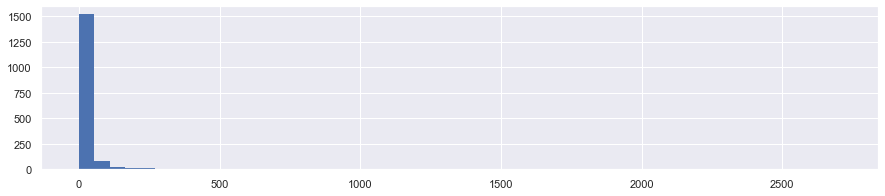

In [25]:
plt.figure(figsize=(15, 3))
plt.hist(citations.street.value_counts().values, bins=50);

In [26]:
# first digit of street number of where citation is issued
# is also included in the dataset
# this provides a more granular location 
citations[['street', 'street_number']]

,street,street_number
0,E Shea Bl,6xxx
1,E Shea Bl,6xxx
2,N Goldwater Bl,4xxx
3,N Goldwater Bl,4xxx
4,N Pima Rd,2xxx
...,...,...
22418,N 104th St / E Shea Bl,xxx
22419,N Alma School Rd / E Happy Valley Rd,xxx
22420,E Frank Lloyd Wright Bl / L101,xxx
22422,E Thomas Rd,7xxx


In [27]:
# create feature for specific location each citation took place at
# in case I want a higher level of detail than provided simply by streets
citations['place_id'] = citations.street + ' - ' + citations.street_number

In [28]:
# "Beat" seems to describe patrol locations within the city
# with the lowest beat numbers being the farthest south
# and the highest beat numbers being in the north

citations.beat.value_counts().sort_index()

1.0     1989
2.0     1325
3.0     2615
4.0     1259
5.0     1265
6.0     3604
7.0     3012
8.0     1136
9.0      977
10.0    2064
11.0    1599
12.0    2359
13.0    1627
14.0    1261
15.0    2294
16.0    1275
17.0    1699
18.0    1099
19.0    3664
20.0    1884
99.0     410
Name: beat, dtype: int64

In [29]:
# examine street locations associated with beat #1
citations.loc[citations.beat == 1, 'street'].value_counts()

E McDowell Rd                  373
N Miller Rd                    269
N Hayden Rd / E McDowell Rd    185
E McKellips Rd                 138
N 68th St / E McDowell Rd       88
                              ... 
N 70th St / E Portland St        1
N 74th St / E Skysong Bl         1
E Fillmore St                    1
N 70th St / E Loma Land DR       1
E Moreland St                    1
Name: street, Length: 97, dtype: int64

In [30]:
# examine street locations associated with beat #10
citations.loc[citations.beat == 10, 'street'].value_counts()

N Scottsdale Rd                       617
E Indian Bend Rd                      401
N Hayden Rd                           149
N Hayden Rd / E Indian Bend Rd        101
E Indian Bend Rd / N Scottsdale Rd     96
                                     ... 
E Doubletree Ranch Rd                   1
E San Rafael DR / E Via Linda           1
E Via De La Escuela                     1
E Del Cadena DR                         1
E Via Paseo Del Sur                     1
Name: street, Length: 79, dtype: int64

In [31]:
# examine street locations associated with beat #20
citations.loc[citations.beat == 20, 'street'].value_counts()

N Scottsdale Rd                244
N Hayden Rd / E Westland DR    144
N Alma School Py               129
E Dynamite Bl                  114
N Pima Rd                       91
                              ... 
N Pima Rd / E Woodley Wy         1
N 67th St / E Dixileta DR        1
N 68th St                        1
E Via Dona Rd                    1
N 64th St / E JOmax Rd           1
Name: street, Length: 167, dtype: int64

In [32]:
# examine street locations associated with beat #99
# this beat clearly doesn't fit in with the normal beat sequencing
citations.loc[citations.beat == 99, 'street'].value_counts()

E McKellips Rd / N Scottsdale Rd     48
E Indian School Rd / N Pima Rd       30
N 90th St / L101                     25
N 64th St / E McDowell Rd            24
E Jackrabbit Rd / N Scottsdale Rd    21
                                     ..
E Stagecoach Pass Rd                  1
E Fillmore St                         1
E Papago DR / N Scottsdale Rd         1
E Lone Mountain Rd                    1
L101 Sb                               1
Name: street, Length: 75, dtype: int64

Beat 99 has fewer citations associated with it, they also seem to be spread out throughout Scottsdale.

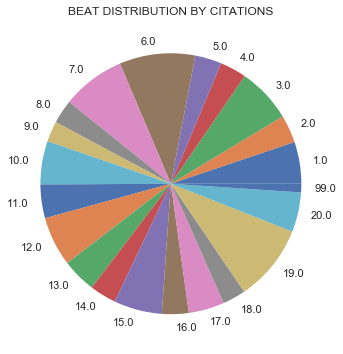

In [33]:
# visualize distribution of beats by citations
plt.figure(figsize=(6, 6))

citations.beat.value_counts().sort_index().rename('').plot(
    kind='pie',
    title='BEAT DISTRIBUTION BY CITATIONS');

Overall citations seem to be quite evenly distributed by beat location.

#### Age of Person Receiving the Citation

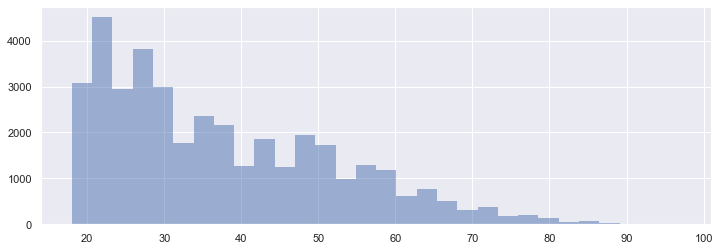

In [34]:
plt.figure(figsize=(12, 4))

plt.hist(citations.cited_person_age, bins=30, alpha=.5);

Ages of people receiving citations clearly skews younger.

#### Hour of the Day in Which Citations are Frequently Issued

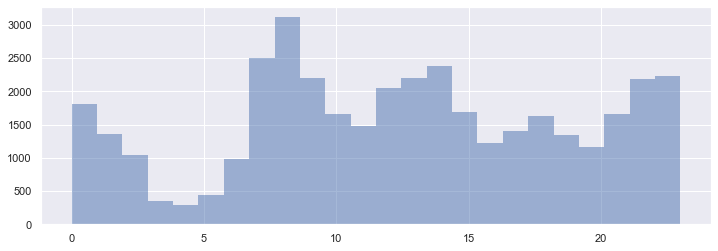

In [35]:
plt.figure(figsize=(12, 4))

plt.hist(citations.hour_of_day, bins=24, alpha=.5);

This distribution looks predictable, with spikes in the morning when people are driving to work, as well as in the afternoon when people are returning from work.  Additionally, there is a spike in the late evening - probably associated with DUIs or disorderly conduct.

#### Day of the Week in Which Citations are Frequently Issued

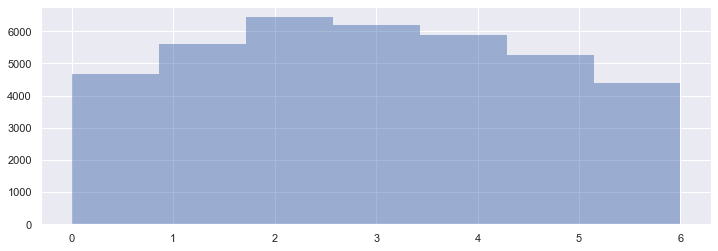

In [36]:
plt.figure(figsize=(12, 4))

plt.hist(citations.day_of_week, bins=7, alpha=.5);

It surprises me that more citations aren't issued on the weekend.

#### Month of the Year in Which Citations are Issued

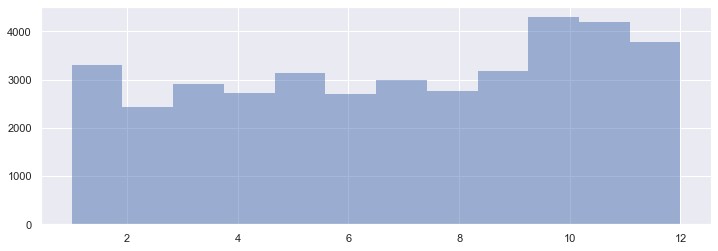

In [37]:
plt.figure(figsize=(12, 4))

plt.hist(citations.month, bins=12, alpha=.5);

It's unclear to me why there are so many citations later in the year, especially October and November.  Also, I would expect a steeper drop during the summer months when fewer cold weather visitors are in the area.

## DEFINE FEATURES TO PERFORM ANALYSIS ON

In [39]:
citations.head()

,arizona_statute_code,beat,charge_description,citation_#,citation_date,citation_time,citation_type_code,citation_type_description,cited_person,cited_person_age,cited_person_ethnicity,cited_person_race,cited_person_sex,city,district,officer_badge_#,state,street,street_number,zip,zone,tcmainid,month,day_of_week,hour_of_day,place_id
0,28-701A,12.0,Speed Greater Than R&P or Posted,8096915,2019-07-10,747,CV,Civil Traffic,"Hansen, Christopher",19.0,N,W,M,Scottsdale,D3,1335,AZ,E Shea Bl,6xxx,NaN,3003,662799,7,2,7,E Shea Bl - 6xxx
1,28-701A,12.0,Speed Greater Than R&P or Posted,8096916,2019-07-10,800,CV,Civil Traffic,"Koch, JOshua",36.0,N,W,M,Scottsdale,D3,1335,AZ,E Shea Bl,6xxx,NaN,3003,662801,7,2,8,E Shea Bl - 6xxx
2,28-701A,7.0,Speed Greater Than R&P or Posted,8096917,2019-07-10,853,CV,Civil Traffic,"Dahl, Renee",61.0,N,W,F,Scottsdale,D2,1335,AZ,N Goldwater Bl,4xxx,NaN,1102,662802,7,2,8,N Goldwater Bl - 4xxx
3,28-701A,7.0,Speed Greater Than R&P or Posted,8096918,2019-07-11,843,CV,Civil Traffic,"Lu, Hung",59.0,N,A,M,Scottsdale,D2,1335,AZ,N Goldwater Bl,4xxx,NaN,1102,662804,7,3,8,N Goldwater Bl - 4xxx
4,28-701A,19.0,Speed Greater Than R&P or Posted,8095091,2019-07-06,2215,CV,Civil Traffic,"Noller-Johnson, Aarron",23.0,U,W,M,Scottsdale,D4,1450,AZ,N Pima Rd,2xxx,NaN,3801,662805,7,5,22,N Pima Rd - 2xxx


In [40]:
# combine features from the dataset I think will be beneficial 
# with those I have created
# with the end goal of clustering in mind

pd.concat([citations[['beat',
                    'cited_person_age',
                    'charge_description']], 
             citations.iloc[:,-4:]], axis=1)

,beat,cited_person_age,charge_description,month,day_of_week,hour_of_day,place_id
0,12.0,19.0,Speed Greater Than R&P or Posted,7,2,7,E Shea Bl - 6xxx
1,12.0,36.0,Speed Greater Than R&P or Posted,7,2,8,E Shea Bl - 6xxx
2,7.0,61.0,Speed Greater Than R&P or Posted,7,2,8,N Goldwater Bl - 4xxx
3,7.0,59.0,Speed Greater Than R&P or Posted,7,3,8,N Goldwater Bl - 4xxx
4,19.0,23.0,Speed Greater Than R&P or Posted,7,5,22,N Pima Rd - 2xxx
...,...,...,...,...,...,...,...
22418,13.0,27.0,No Proof of Insurance,9,5,22,N 104th St / E Shea Bl - xxx
22419,20.0,35.0,Fail to Stop at Stop Sign,9,5,22,N Alma School Rd / E Happy Valley Rd - xxx
22420,16.0,20.0,Speed Greater Than R&P or Posted,9,6,12,E Frank Lloyd Wright Bl / L101 - xxx
22422,3.0,22.0,Failure to Control Speed to Avoid A Collision,10,1,16,E Thomas Rd - 7xxx


In [41]:
# export features to CSV

pd.concat([citations[['beat',
                    'cited_person_age',
                    'charge_description']], 
             citations.iloc[:,-4:]], axis=1).to_csv('data/clustering_features.csv', index=False)